<a href="https://colab.research.google.com/github/lucasmcordeiro/DeepLearning/blob/main/LeNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook criado para iniciar meu treinamento em deeplearning usando pytorch

In [1]:
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchsummary import summary

In [47]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
device = torch.device(device)

Using cuda device


In [48]:
device

device(type='cuda')

Downloading train and test data

MNIST dataset resource: https://yann.lecun.com/exdb/mnist/

In [44]:
TrainMNIST = datasets.MNIST(root="images/", train=True, download=True, transform=ToTensor())
TestMNIST = datasets.MNIST(root="images/", train=False, download=True, transform=ToTensor())

In [45]:
data_loader_train = DataLoader(TrainMNIST, batch_size=64,)
data_loader_test = DataLoader(TestMNIST, batch_size=64)

In [5]:
for X, y in data_loader_test:
  print(X.shape)
  print(y)
  break

torch.Size([64, 1, 28, 28])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])


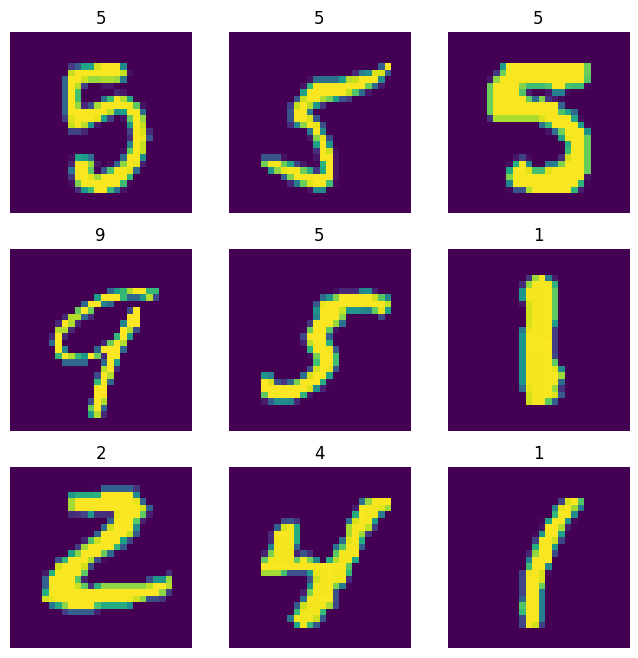

In [6]:
figure = plt.figure(figsize=(8,8))
cols, rows = (3,3)

for i in range(1,cols*rows + 1):
  sample_idx = torch.randint(len(TrainMNIST), size=(1,)).item()
  img, label = TrainMNIST[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(label)
  plt.axis("off")
  plt.imshow(img.squeeze())

plt.show()

The LeNet Architecture used expects a 32 x 32 input image size, but the dataset has images with 28 x 28 size, so I added a padding = 2 in the first convolutional layer.

In [7]:
class leNET(nn.Module):
  def __init__(self) -> None:
    super(leNET,self).__init__()

    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5), stride=1, padding=2),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=(2,2), stride=2),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5), stride=1),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=(2,2), stride=2),
        nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5,5), stride=1),
        nn.Tanh())


    self.classifier = nn.Sequential(
        nn.Linear(in_features=120, out_features=84),
        nn.ReLU(),
        nn.Linear(in_features=84, out_features=10))

  def forward(self, x):
    x = self.feature_extractor(x)
    x = nn.Flatten()(x)
    x = self.classifier(x)
    x = nn.Softmax(dim=1)(x)
    return x



In [53]:
model = leNET().to(device)

In [54]:
next(model.parameters()).device

device(type='cuda', index=0)

In [56]:
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              Tanh-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7            [-1, 120, 1, 1]          48,120
              Tanh-8            [-1, 120, 1, 1]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [57]:
learing_rate=0.001
batch_size=64
epochs=5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learing_rate)

Testing the model inputs and outputs

In [58]:
  img, label = TrainMNIST[sample_idx]
  label = torch.tensor([label]).to(device)
  img = img.unsqueeze(0).to(device)
  pred = model(img)

  print(pred)
  print(label)
  print(loss_fn(pred, label))


tensor([[0.0955, 0.1087, 0.1104, 0.1034, 0.0981, 0.0964, 0.1046, 0.0868, 0.0945,
         0.1016]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([3], device='cuda:0')
tensor(2.2992, device='cuda:0', grad_fn=<NllLossBackward0>)


The following code is based on pytorch documentation: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

In [61]:
def train_loop(data_loader_train, model, loss_fn, optimizer):
  size = len(data_loader_train.dataset)
  model.train()
  for batch, (images, labels) in enumerate(data_loader_train):
    images = images.to(device)
    labels = labels.to(device)
    #Compute prediction and loss
    outputs = model(images)
    loss = loss_fn(outputs, labels)

    #Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch % 100 == 0:
        loss, current = loss.item(), batch * batch_size + len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [62]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(data_loader_train, model, loss_fn, optimizer)
    test_loop(data_loader_test, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302074  [   64/60000]
loss: 1.706915  [ 6464/60000]
loss: 1.565181  [12864/60000]
loss: 1.552731  [19264/60000]
loss: 1.576885  [25664/60000]
loss: 1.556743  [32064/60000]
loss: 1.512423  [38464/60000]
loss: 1.576863  [44864/60000]
loss: 1.526038  [51264/60000]
loss: 1.529329  [57664/60000]
Test Error: 
 Accuracy: 95.1%, Avg loss: 1.513432 

Epoch 2
-------------------------------
loss: 1.495479  [   64/60000]
loss: 1.498405  [ 6464/60000]
loss: 1.519176  [12864/60000]
loss: 1.503489  [19264/60000]
loss: 1.502429  [25664/60000]
loss: 1.505607  [32064/60000]
loss: 1.477439  [38464/60000]
loss: 1.515066  [44864/60000]
loss: 1.506768  [51264/60000]
loss: 1.523539  [57664/60000]
Test Error: 
 Accuracy: 96.3%, Avg loss: 1.499042 

Epoch 3
-------------------------------
loss: 1.487679  [   64/60000]
loss: 1.478705  [ 6464/60000]
loss: 1.506878  [12864/60000]
loss: 1.493212  [19264/60000]
loss: 1.496362  [25664/60000]
loss: 1.486546  [32064/600

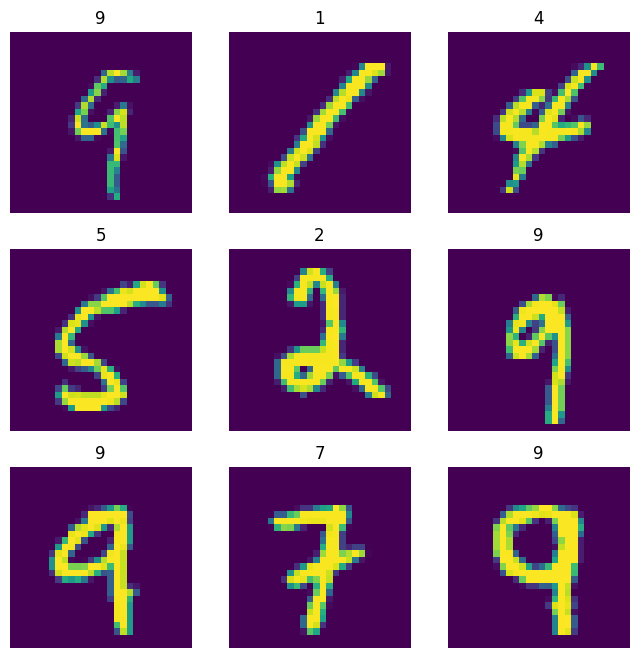

In [65]:
figure = plt.figure(figsize=(8,8))
cols, rows = (3,3)
with torch.no_grad():
  for i in range(1,cols*rows + 1):
    sample_idx = torch.randint(len(TrainMNIST), size=(1,)).item()
    img, label = TrainMNIST[sample_idx]
    img = img.to(device)
    img = img.unsqueeze(0)

    pred = model(img)
    pred = pred.argmax(1).item()
    figure.add_subplot(rows, cols, i)
    plt.title(pred)
    plt.axis("off")
    plt.imshow(img.squeeze().to('cpu'))

  plt.show()